<a href="https://www.kaggle.com/code/esmi734/c964-capstone-content-based-video-game-recommend?scriptVersionId=117953070" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**This Jupyter Notebook will serve as a proof of concept for a content based video game recommendation system. It was created in part with a guide found [here](http://www.datacamp.com/tutorial/recommender-systems-python). It will pull from data from IMDB on over 20k video games, including user ratings, as well as total number of users who rated each game. The recommender system will use Natural Language Processing on the 'plot' column of each game. It will then use cosine similarity to calculate the numerical difference between an example game and every other game in our dataset. Mathematically, cosine similarity is represented by the following equation:**

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1590782185/cos_aalkpq.png)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer # NLP and TF-IDF Vectorization
from sklearn.metrics.pairwise import linear_kernel # Import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-video-games/imdb-videogames.csv


In [2]:
games_df = pd.read_csv('../input/imdb-video-games/imdb-videogames.csv')

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20803 entries, 0 to 20802
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   20803 non-null  int64  
 1   name         20803 non-null  object 
 2   url          20803 non-null  object 
 3   year         20536 non-null  float64
 4   certificate  7903 non-null   object 
 5   rating       11600 non-null  float64
 6   votes        11600 non-null  object 
 7   plot         20803 non-null  object 
 8   Action       20803 non-null  bool   
 9   Adventure    20803 non-null  bool   
 10  Comedy       20803 non-null  bool   
 11  Crime        20803 non-null  bool   
 12  Family       20803 non-null  bool   
 13  Fantasy      20803 non-null  bool   
 14  Mystery      20803 non-null  bool   
 15  Sci-Fi       20803 non-null  bool   
 16  Thriller     20803 non-null  bool   
dtypes: bool(9), float64(2), int64(1), object(5)
memory usage: 1.4+ MB


**Now we need to remove the video game entries that have no info added into their 'plot' section. In this dataset, these entries have a string "Add a Plot" in this column. We also need to remove any entries that have dulplicate names, as this will confuse the cosine similarity function, and try to return more than one array, which will cause a ValueError. After dropping these, we will need to re-index our dataframe, so that any search will remain within range.**

In [3]:
no_plot = games_df[games_df['plot'].__eq__('Add a Plot')].index

games_df.drop(index=no_plot, inplace=True)
games_df = games_df.drop_duplicates(subset='name', keep="first", inplace=False)
games_df = games_df.reset_index()

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11096 entries, 0 to 11095
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        11096 non-null  int64  
 1   Unnamed: 0   11096 non-null  int64  
 2   name         11096 non-null  object 
 3   url          11096 non-null  object 
 4   year         10988 non-null  float64
 5   certificate  5741 non-null   object 
 6   rating       8051 non-null   float64
 7   votes        8051 non-null   object 
 8   plot         11096 non-null  object 
 9   Action       11096 non-null  bool   
 10  Adventure    11096 non-null  bool   
 11  Comedy       11096 non-null  bool   
 12  Crime        11096 non-null  bool   
 13  Family       11096 non-null  bool   
 14  Fantasy      11096 non-null  bool   
 15  Mystery      11096 non-null  bool   
 16  Sci-Fi       11096 non-null  bool   
 17  Thriller     11096 non-null  bool   
dtypes: bool(9), float64(2), int64(2), object(5)
me

**We have greatly shortened our list of games, from 20,803 to 11,096.** 

**Now we will perform the language processing on the 'plot' column, removing the "Stop words" from each plot, and use each plot to create a TF-IDF matrix:**

In [4]:
#Define a TF-IDF Vectorizer Object. We will also get rid of all english "stop words" such as 'the', 'a', or 'an'
tfidf = TfidfVectorizer(stop_words='english')

#Replace any NaN values with an empty string
games_df['plot'] = games_df['plot'].fillna('')

#Create the required TF-IDF matrix by fitting and transforming the data, taking the 'plot' column as an input.
tfidf_matrix = tfidf.fit_transform(games_df['plot'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(11096, 22813)

**Next, we can take a look at some of the words that included in our TD-IDF matrix:**

In [5]:
tfidf.get_feature_names_out()[2000:2100]

array(['bacterians', 'bad', 'badass', 'badder', 'baddest', 'baddie',
       'baddies', 'badge', 'badguy', 'badiya', 'badlands', 'badly',
       'badman', 'badou', 'baffled', 'baffling', 'bag', 'baggins', 'bags',
       'bahamas', 'bahamian', 'bahamut', 'bahis', 'bahram', 'bahro',
       'baibin', 'baird', 'bajoran', 'bake', 'baked', 'baker', 'baking',
       'bakram', 'bakterius', 'bakugan', 'bakumatsu', 'balance',
       'balanced', 'balancing', 'balasar', 'balboa', 'bald', 'balder',
       'baldi', 'balduq', 'baldur', 'balduran', 'balkans', 'ball',
       'ballad', 'ballade', 'ballads', 'ballet', 'balloon', 'balloons',
       'balls', 'ballz', 'balor', 'balta', 'balthazar', 'baltic', 'bam',
       'bambi', 'bambo', 'bamm', 'ban', 'banana', 'bananas', 'banchou',
       'band', 'bandage', 'bandai', 'bandersnatch', 'bandicoot',
       'bandicoots', 'bandit', 'bandits', 'bandmate', 'bandmates',
       'bands', 'bane', 'baneful', 'bang', 'banga', 'banish', 'banished',
       'banjo', 'ban

**We can also look at the shape of our cosine similarity matrix, and see a few of its entries, to make sure it looks correct:**

In [6]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim

array([[1.        , 0.        , 0.06084075, ..., 0.03122042, 0.04619231,
        0.0279481 ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06084075, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03122042, 0.        , 0.        , ..., 1.        , 0.05256253,
        0.03180232],
       [0.04619231, 0.        , 0.        , ..., 0.05256253, 1.        ,
        0.04705326],
       [0.0279481 , 0.        , 0.        , ..., 0.03180232, 0.04705326,
        1.        ]])

In [7]:
cosine_sim.shape

(11096, 11096)

**We can get a look, albeit not very detailed, of this large matrix by plotting it:**

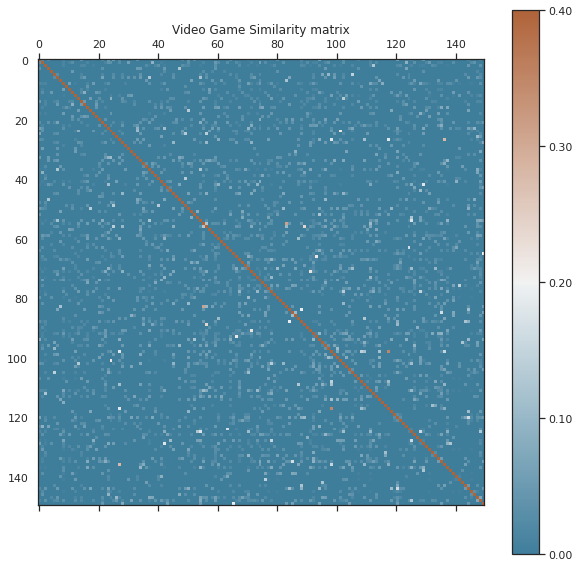

In [8]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10,10))

plot_cos = cosine_sim[900:1050, 900:1050]

cax = ax.matshow(plot_cos, interpolation = 'nearest', cmap = sns.diverging_palette(230, 30, as_cmap=True), vmax = 0.4)

plt.title('Video Game Similarity matrix')

fig.colorbar(cax, ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1])
plt.show()

**As can be seen, a large majority of games' plots don't have a great amount of similarity. The graph actually has been adjusted to show more similarity; the max value has been set to 0.4, rather than the usual 1.0. Anything higher than 0.4 will register as 1. Additionally, we have zoomed in on a slice of the 11,096 x 11,096 matrix, to show more granularity. It's important to note that if 1 were the maximum value, any other 1:1 matches were visible in the above matrix plot, it would indicate a duplicate entry, rather than two separate, similar data points, given the amount of dissimilarity in the dataset.**

**Now, in order to create a function which will return a list of similar games after inputing the title of one game, we need a reference of the indices of each game based on the title string. We will create that now:**

In [9]:
indices = pd.Series(games_df.index, index=games_df['name'])

**Now we need to create our recommendation function. It will have to do a couple of things:**
1. Retrieve the index of the game inputted, given its title
2. Get that game's cosine similarity to all other games on our list (11,929)
3. Convert that cosine similarity list into a tuple list, where the first element is the position, and the second is its similarity score
4. Sort the tuple list based on their similarity scores
5. Get the top 10 results, ignoring the 1st result, as it will refer to the inputted game itself (it has a score of 1 in similarity, after all)
6. Print the names that match the indices of those top 10 results


In [10]:
def game_recommendation(name, cosine_sim=cosine_sim):
    #Get the index of the inputted game
    indx = indices[name]
    
    #Get the inputted game's list of similarity scores with all other games
    similarity_scores = list(enumerate(cosine_sim[indx]))
    
    #Sort the games by similarity score
    similarity_scores = sorted(similarity_scores, key=lambda x:x[1], reverse=True)
    
    #Get the top ten results
    similarity_scores = similarity_scores[1:11]
    
    #Get the game indices
    game_indices = [i[0] for i in similarity_scores]
    
    #Return top 10 most similar games
    return games_df['name'].iloc[game_indices], similarity_scores

In [11]:
game_recommendation("Samurai Warriors 3")

(2766                          Samurai Shodown
 1051                           Shadow Fight 2
 814         Samurai Jack: Battle Through Time
 4551     Blades of Blood: Samurai Shodown III
 3759                       Samurai Warriors 2
 1465                         Samurai Champloo
 8936                          World of Demons
 4594    Samurai Shodown IV: Amakusa's Revenge
 3105                       Way of the Samurai
 8997                            Sengoku Asura
 Name: name, dtype: object,
 [(2766, 0.4241217424884039),
  (1051, 0.38795162233838504),
  (814, 0.37012320054364534),
  (4551, 0.3688836048550602),
  (3759, 0.3623767922356582),
  (1465, 0.3620738754900029),
  (8936, 0.3524425828014308),
  (4594, 0.3320299005309083),
  (3105, 0.28769122600618674),
  (8997, 0.27350035028253517)])

**The system seems to have correctly picked up on a 'Samurai' theme.**

In [12]:
game_recommendation("Yakuza Kiwami")

(458                               Yakuza
 602                      Yakuza Kiwami 2
 1506                            Yakuza 2
 414                             Judgment
 1041                            Yakuza 5
 976                             Yakuza 3
 3762    The Yakuza Remastered Collection
 712           Yakuza 6: The Song of Life
 4156                     Samurai Western
 121                             Yakuza 0
 Name: name, dtype: object,
 [(458, 0.4042118098610428),
  (602, 0.2768148459877009),
  (1506, 0.2722669747239814),
  (414, 0.20895269151666812),
  (1041, 0.20404393874193344),
  (976, 0.1799595400408486),
  (3762, 0.1789770259708825),
  (712, 0.15762006141396884),
  (4156, 0.1556060441446856),
  (121, 0.1507979514749505)])

In [13]:
game_recommendation("The Last of Us")

(375         The Last of Us: Left Behind
 5               The Last of Us: Part II
 6031      Infectonator: World Dominator
 9415                     Infectonator 2
 5668                           Overland
 867                        Conan Exiles
 622      Death Stranding Director's Cut
 1480                       Resistance 3
 39                            Days Gone
 11056                      Crimson Gray
 Name: name, dtype: object,
 [(375, 0.23632482980749148),
  (5, 0.23010114518997066),
  (6031, 0.20293585275132983),
  (9415, 0.1948186238320071),
  (5668, 0.19477521413439422),
  (867, 0.1912660795301539),
  (622, 0.17423055100078857),
  (1480, 0.16519867834255178),
  (39, 0.15344759564716567),
  (11056, 0.15280484878984485)])

In [14]:
game_recommendation("God of War")

(127                      God of War II
 8959      Legends of Norrath Travelers
 9071                     Clash of Gods
 397      God of War: Chains of Olympus
 546                              Smite
 4754                Praey for the Gods
 1546                         Sacrifice
 10312       Imre's Curse: The Prologue
 3347                      Gods of Rome
 10953            Gambling with Science
 Name: name, dtype: object,
 [(127, 0.37412428880423676),
  (8959, 0.27149942448972386),
  (9071, 0.2640037477231861),
  (397, 0.2491682127217182),
  (546, 0.2098479612314906),
  (4754, 0.2095223243929273),
  (1546, 0.19185756147123578),
  (10312, 0.1878154634427232),
  (3347, 0.18214527260519373),
  (10953, 0.1773045936707584)])